In [1]:

import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from envs.Env_2 import Mult_asset_env
import matplotlib.pyplot as plt


2025-08-14 22:15:13.450858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755206113.513747   24835 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755206113.532499   24835 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 22:15:13.579584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# assets = ['NVDA', 'AAPL', 'AMZN', 'JPM', 'IBM', 'MSFT', 'TSLA', 'GOOGL', 'META', 'HSBC']
# start_date = '2019-01-01'
# end_date = '2025-01-01'


# for symbol in assets:
#     df = yf.download(tickers = assets,
#                     start = start_date,
#                     end = end_date,
#                     interval = '1d',
#                     auto_adjust=True)
#     sta = df.stack()
#     df_flt = sta.reset_index()
#     df_flt.to_csv(f'/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/{symbol}_daily.CSV')

In [3]:
address1 = "/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/AAPL_daily.CSV"

apple_df = pd.read_csv(address1,
                  parse_dates=['Date'],
                  index_col='Date',
                  engine='pyarrow',
                  dtype_backend='pyarrow'
                  )

address2 = "/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/MSFT_daily.CSV"

MSFT_df = pd.read_csv(address2,
                  parse_dates=['Date'],
                  index_col='Date',
                  engine='pyarrow',
                  dtype_backend='pyarrow'
                  )

apple_df['Ticker'] = 'AAPL'
MSFT_df['Ticker'] = 'MSFT'
df = pd.concat([apple_df, MSFT_df], axis=0) 

In [4]:
df

,,Ticker,Close,High,Low,Open,Volume
Date,,,,,,,
2019-01-02,0,AAPL,37.617844,37.839379,36.738855,36.896073,148158800
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200
...,...,...,...,...,...,...,...
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200
2024-12-27,1507,MSFT,428.881104,433.553144,424.71712,432.935523,18117700


In [5]:
def change (x):
    x['Ch_tomorrow'] = (x.groupby('Ticker')['Close']).pct_change(-1) * 100
    x = x.dropna().copy()
    x['Ch_direction'] = np.where(x.Ch_tomorrow > 0, 'UP', 'DOWN')

    return x


df = change(df).copy()


In [6]:
df

,,Ticker,Close,High,Low,Open,Volume,Ch_tomorrow,Ch_direction
Date,,,,,,,,,
2019-01-02,0,AAPL,37.617844,37.839379,36.738855,36.896073,148158800,11.062642,UP
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800,-4.094155,DOWN
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400,0.22307,UP
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200,-1.870641,DOWN
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200,-1.669831,DOWN
...,...,...,...,...,...,...,...,...,...
2024-12-23,1504,MSFT,433.583038,435.973841,431.172293,435.067322,19152500,-0.928677,DOWN
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500,0.278463,UP
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200,1.76062,UP


In [7]:
def normalization (x):
    
    x = x.copy()
    
    x['Log_return'] = (x.groupby('Ticker')['Close'].transform(lambda i: np.log( i / i.shift(1))))
     
    x = x.dropna().copy()
    
    x['Log_return_Z'] = (x.groupby('Ticker')['Close'].transform(lambda i: ( i - i.mean()) /  i.std()))
    
    return x 

df = normalization(df).copy()

In [8]:
df

,,Ticker,Close,High,Low,Open,Volume,Ch_tomorrow,Ch_direction,Log_return,Log_return_Z
Date,,,,,,,,,,,
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800,-4.094155,DOWN,-0.104924,-1.871672
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400,0.22307,UP,0.041803,-1.8449
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200,-1.870641,DOWN,-0.002228,-1.846355
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200,-1.669831,DOWN,0.018884,-1.833917
2019-01-09,5,AAPL,36.519714,36.810329,35.64311,36.038533,180396400,-0.318606,DOWN,0.016839,-1.822626
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,1504,MSFT,433.583038,435.973841,431.172293,435.067322,19152500,-0.928677,DOWN,-0.003097,1.790261
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500,0.278463,UP,0.009330,1.83231
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200,1.76062,UP,-0.002781,1.819737


In [9]:
df.isna().sum()

                0
Ticker          0
Close           0
High            0
Low             0
Open            0
Volume          0
Ch_tomorrow     0
Ch_direction    0
Log_return      0
Log_return_Z    0
dtype: int64

In [10]:
# Features

def recommended_features(data):
    
    
        
    if isinstance(data.index, pd.MultiIndex):
        data = data.reset_index()
        
    if '' in data.columns:
        data = data.drop(columns=[''])
        
        
    #MA
    data['MA_10'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 10, min_periods = 1).mean())
    data['MA_50'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 50, min_periods = 1).mean())
    data['MA_200'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 200, min_periods = 1).mean())
    
    #RSI
    data['RSI'] = data.groupby('Ticker')['Close'].transform(lambda x: ta.rsi(x, length = 20))

    #MACD
    data['MACD'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 12, adjust=False).mean() - x.ewm(span = 26, adjust = False).mean())
    
    data = data.dropna().copy()
    
    #ATR
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data.groupby('Ticker')['Close'].shift())
    low_close =  np.abs(data['Low'] - data.groupby('Ticker')['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    data['TrueRange'] = true_range
    data['ATR'] = data.groupby('Ticker')['TrueRange'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
    data = data.drop(columns=['TrueRange'])
    
    
    
    return data


df = recommended_features(df)

In [11]:
print(df)
print(df.isna().sum())

           Ticker       Close        High         Low        Open     Volume  \
Date                                                                           
2019-02-01   AAPL   39.666454   40.252445   39.525909   39.771267  130672400   
2019-02-04   AAPL   40.793159   40.890826   39.847473   39.878441  125982000   
2019-02-05   AAPL   41.491123   41.705513   41.055205    41.17669  144406400   
2019-02-06   AAPL   41.505413   41.822231   41.174304   41.603076  112958400   
2019-02-07   AAPL   40.719334   41.433959   40.576407   41.067116  126966800   
...           ...         ...         ...         ...         ...        ...   
2024-12-23   MSFT  433.583038  435.973841  431.172293  435.067322   19152500   
2024-12-24   MSFT  437.647369  437.916355  432.527071  432.985301    7164500   
2024-12-26   MSFT  436.432068  439.251246  434.957756  437.398354    8194200   
2024-12-27   MSFT  428.881104  433.553144   424.71712  432.935523   18117700   
2024-12-30   MSFT  423.202911  425.91249

In [12]:
def shrinking_ings (x):
    mapping = {}
    for col in x.dtypes [x.dtypes == 'int64[pyarrow]'].index:
        max_ = x[col].max()
        min_ = x[col].min()
        if min_ < 0:
            continue
        elif max_ < 255:
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:
            mapping[col] = 'uint16[pyarrow]'
        elif max_ < 4294967295:
            mapping[col] = 'uint32[pyarrow]'
    return x.astype(mapping)

df = shrinking_ings(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2976 entries, 2019-02-01 to 2024-12-30
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Ticker        2976 non-null   object         
 1   Close         2976 non-null   double[pyarrow]
 2   High          2976 non-null   double[pyarrow]
 3   Low           2976 non-null   double[pyarrow]
 4   Open          2976 non-null   double[pyarrow]
 5   Volume        2976 non-null   uint32[pyarrow]
 6   Ch_tomorrow   2976 non-null   double[pyarrow]
 7   Ch_direction  2976 non-null   object         
 8   Log_return    2976 non-null   float64        
 9   Log_return_Z  2976 non-null   double[pyarrow]
 10  MA_10         2976 non-null   float64        
 11  MA_50         2976 non-null   float64        
 12  MA_200        2976 non-null   float64        
 13  RSI           2976 non-null   float64        
 14  MACD          2976 non-null   float64        
 15  ATR        

In [14]:
# num_assets = len(df['Ticker'].unique())
# feature_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MA_10', 'MA_50', 'MA_200']

# env = DummyVecEnv([lambda: Mult_asset_env(df=df,
#                                           num_assets=num_assets,
#                                           features_list=feature_list,
#                                           window_size=5)])
# print ("\n --- Initializing A2C Model and Starting Training ---")
# model_A2C = A2C('MlpPolicy', env, verbose=1)

# model_A2C.learn(total_timesteps=10000)

# print('\n --- A2C Model Training Finished ---')
# print("You can now evaluate the trained model_A2C or save it for later use.")

In [15]:
unique_dates = df.index.unique()
split_date_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_date_index]
test_dates = unique_dates[split_date_index:]

df_train = df[df.index.isin(train_dates)]
df_test = df[df.index.isin(test_dates)]

/home/micheal/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 ---Initializing A2C Model and Starting Training ---
Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 55       |
|    iterations         | 100      |
|    time_elapsed       | 8        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.32    |
|    explained_variance | -35.9    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0961  |
|    std                | 1.02     |
|    value_loss         | 0.00109  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 49       |
|    iterations         | 200      |
|    time_elapsed       | 20       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.39    |
|    explained_variance | -16.9    |
|    learning_rate      | 0.0007   |
|   

/home/micheal/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- TEST ROLLOUT ---

--- Final portfolio Holdings ---
Total value: 1000.00
Final Cash: 1000.00
Final Asset Holdings:
 AAPL: 0.0000 shares
 MSFT: 0.0000 shares


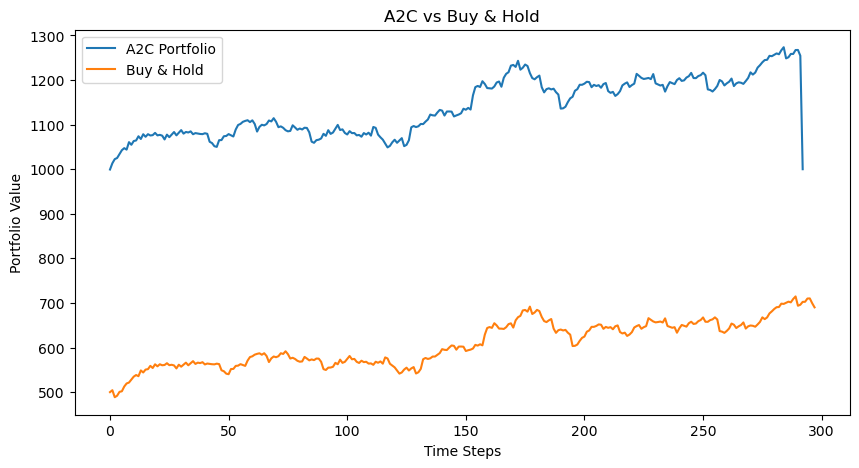

In [17]:
num_assets = len(df['Ticker'].unique())
feature_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MA_10', 'MA_50', 'MA_200']

# train_env = DummyVecEnv([lambda: Mult_asset_env(df=df_train,
#                                           num_assets=num_assets,
#                                           features_list=feature_list,
#                                           window_size=5)])

# print ('\n ---Initializing A2C Model and Starting Training ---')
# model_A2C = A2C('MlpPolicy', train_env, verbose=1, gamma=0.99, ent_coef=0.01)

# model_A2C.learn(total_timesteps=200000)

# print ('\n --- A2C Model Training Finished ---')
# print ('You can now evaluate the trained model_A2C or save it for later use.')

# test_env = DummyVecEnv([lambda: Mult_asset_env(df=df_test,
#                                           num_assets=num_assets,
#                                           features_list=feature_list,
#                                           window_size=5)])

# obs = test_env.reset()
# portfolio_values = []
# for _ in range(len(df_test) - 5):
#     action, _states = model_A2C.predict(obs, deterministic=True)
#     print(action)
#     obs, rewards, dones, info = test_env.step(action)

#     test_env.envs[0].render()
    
#     portfolio_values.append(test_env.envs[0].balance)
#     if dones:
#         break
# final_env = test_env.envs[0]
# final_holdings = {
#     'cash': final_env.cash,
#     'total_value': final_env.balance,
#     'asset': {
#         ticker: shares for ticker, shares in zip(final_env.tickers, final_env.assets_shares)
#     }
# }
# print("\n--- Final portfolio Holdings ---")
# print(f'Total value: {final_holdings['total_value']:.2f}')
# print(f'Final Cash: {final_holdings['cash']:.2f}')
# print("Final Asset Holdings:")
# for ticker, shares in final_holdings['asset'].items():
#     print(f' {ticker}: {shares:.2f} shares')

# initial_cash = 1000
# tickers = df['Ticker'].unique()

# first_prices = []
# last_prices = []
# for ticker in tickers:
#     df_ticker = df_test[df_test['Ticker'] == ticker]
#     first_prices.append(df_ticker['Close'].iloc[0])
#     last_prices.append(df_ticker['Close'].iloc[-1])

# shares_per_asset = (initial_cash / len(tickers)) / np.array(first_prices)


# bh_values = []
# test_dates = df_test.index.unique()
# for i in range(len(test_dates)):
#     current_date = test_dates[i]
#     total_value = 0
#     for j, ticker in enumerate(tickers):
#         price = df_test[(df_test.index == current_date) & (df_test['Ticker'] == ticker)]['Close'].iloc[0]
#         total_value += shares_per_asset[j] * price
#     bh_values.append(total_value)
def make_train():
    return Mult_asset_env(
        df=df_train,
        num_assets=num_assets,
        features_list=feature_list,
        window_size=5,
        initial_balance=1000,
        transaction_cost_rate=0.001,
        risk_aversion=0.10,
        cash_penalty=0.02,
        invest_bouns=0.001,
        vol_window=20,
        clip_return=0.10
    )
    
def make_test():
    return Mult_asset_env(
        df=df_test,
        num_assets=num_assets,
        features_list=feature_list,
        window_size=5,
        initial_balance=1000,
        transaction_cost_rate=0.001,
        risk_aversion=0.10,
        cash_penalty=0.02,
        invest_bouns=0.001,
        vol_window=20,
        clip_return=0.10
    )

train_env = DummyVecEnv([make_train])

print ('\n ---Initializing A2C Model and Starting Training ---')
model_A2C = A2C(
    'MlpPolicy', 
    train_env, 
    verbose=1, 
    gamma=0.99, 
    ent_coef=0.01,
    learning_rate=7e-4
)

model_A2C.learn(total_timesteps=200_000)

print ('\n --- A2C Model Training Finished ---')

test_env = DummyVecEnv([make_test])
obs = test_env.reset()
portfolio_values = []

print ('\n--- TEST ROLLOUT ---')
while True:
    action, _ = model_A2C.predict(obs, deterministic=True)
    obs, rewards, dones, infos = test_env.step(action)
    
    test_env.envs[0].render()
    portfolio_values.append(test_env.envs[0].balance)
    if dones:
        break

final_env = test_env.envs[0]
print("\n--- Final portfolio Holdings ---")
print(f'Total value: {final_env.balance:.2f}')
print(f'Final Cash: {final_env.cash:.2f}')
print("Final Asset Holdings:")
for ticker, shares in zip(final_env.tickers, final_env.assets_shares):
    print(f' {ticker}: {shares:.4f} shares')
    
initial_cash = 1000.0
tickers = final_env.tickers

test_dates = final_env.dates
first_prices = final_env._daily_idx[test_dates[0]]['Close'].values
shares_per_asset = (initial_cash / len(ticker)) / np.array(first_prices)

bh_values = []
for d in test_dates:
    prices = final_env._daily_idx[d]['Close'].values
    bh_values.append(float(np.sum(shares_per_asset * prices)))

plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label = "A2C Portfolio")
plt.plot(bh_values, label='Buy & Hold')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.title('A2C vs Buy & Hold')
plt.legend()
plt.show()